In [1]:
import numpy as np

In [2]:
from scipy.stats import poisson

In [3]:
import matplotlib.pyplot as plt

In [4]:
import pandas as pd

In [5]:
import sys
sys.path.append('..')
from inference.simulation import simBetaPoisson
from scipy import special
from scipy.stats import poisson,norm
from scipy.special import j_roots
from scipy.special import beta as beta_fun  
from scipy.stats import spearmanr

In [6]:
def getProbNoExpr(params):
    kon = params[0]
    koff = params[1]
    ksyn = params[2]
    return dBP_dict(np.array([0]),kon,koff,ksyn)[0]

In [7]:
def dBP_dict(at, alpha, bet, lam):
    at_ = np.copy(at)
    at_.shape = (len(at_), 1)
    np.repeat(at_, 40, axis = 1)
    def fun(at_, m):
        if(max(m) < 1e6):
            return(poisson.pmf(at_,m))
        else:
            return(norm.pdf(at_,loc=m,scale=sqrt(m)))
    x,w = j_roots(40,alpha = bet - 1, beta = alpha - 1)
    gs = np.sum(w*fun(at_, m = lam*(1+x)/2), axis=1)
    prob = 1/beta_fun(alpha, bet)*2**(-alpha-bet+1)*gs
    return {k: v for k, v in zip(at.tolist(), prob.tolist())}

In [8]:
def get_ME_prob(l1,l2):
    return poisson.pmf(0, l2)*(1-poisson.pmf(0, l1))

In [60]:
def get_BI_prob(l1,l2):
    return (1-poisson.pmf(0, l2))*(1-poisson.pmf(0, l1))

In [61]:
def get_SI_prob(l1,l2):
    return poisson.pmf(0, l2)*poisson.pmf(0, l1)

In [9]:
UMI = pd.read_csv('../tx_revision/SS3_c57_UMIs_concat.csv', index_col=0)
params = pd.read_pickle('/home/antonl/parameters/SS3_c57_UMIs_concat_ML.pkl')

In [10]:
UMI_cast = pd.read_csv('../tx_revision/SS3_cast_UMIs_concat.csv', index_col=0)
params_cast = pd.read_pickle('/home/antonl/parameters/SS3_cast_UMIs_concat_ML.pkl')

In [11]:
gof_df = pd.read_csv('good_fibroblast_genes.csv', index_col=0)
goodgenes = gof_df.index.values

In [12]:
params = params[params[1]][0]
params_cast = params_cast[params_cast[1]][0]

params = pd.DataFrame(params)
params_cast = pd.DataFrame(params_cast)

In [13]:
noexprP_c57 = {}
noexprP_cast = {}
for gene in goodgenes:
    noexprP_c57[gene] = getProbNoExpr(params.loc[gene][0])
    noexprP_cast[gene] = getProbNoExpr(params_cast.loc[gene][0])

In [14]:
noexprData_c57 = {}
noexprData_cast = {}
for gene in goodgenes:
    noexprData_c57[gene] = np.mean(UMI.loc[gene][pd.notnull(UMI.loc[gene])] == 0)
    noexprData_cast[gene] = np.mean(UMI_cast.loc[gene][pd.notnull(UMI_cast.loc[gene])] == 0)

In [15]:
in_c57_in_cast = {}
in_c57_not_cast = {}
in_cast_not_c57 = {}
not_c57_not_cast = {}
mean_expr = {}
for gene in goodgenes:
    in_c57 = UMI.loc[gene][pd.notnull(UMI.loc[gene])] != 0
    in_cast = UMI_cast.loc[gene][pd.notnull(UMI_cast.loc[gene])] != 0
    in_c57_in_cast[gene] = np.mean(in_cast*in_c57)
    in_cast_not_c57[gene] = np.mean(in_cast*(~in_c57))
    in_c57_not_cast[gene] = np.mean(in_c57*(~in_cast))
    not_c57_not_cast[gene] = np.mean((~in_c57)*(~in_cast))

/home/nbserver/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


In [16]:
expr_df = pd.DataFrame([noexprData_c57, noexprData_cast, in_c57_in_cast, in_cast_not_c57, in_c57_not_cast, not_c57_not_cast, noexprP_c57, noexprP_cast], index=['silent_c57', 'silent_cast', 'biallelic','mono_cast','mono_c57', 'silent', 'p_silent_c57','p_silent_cast']).T

In [17]:
total_mean = UMI+UMI_cast

In [18]:
biallelic = ((UMI==0)*(UMI_cast>0)).astype(int)

Myo5b              0.004464
Mpzl2              0.004464
Icam5              0.004566
Faah               0.008929
BC021614           0.008929
Pdzk1ip1           0.008929
Galnt3             0.008969
Atf7ip2            0.008969
2410004P03Rik      0.008969
Runx3              0.008969
Marco              0.008969
AA543186           0.008969
Megf10             0.008969
Fras1              0.008969
Dock8              0.008969
Gpr123             0.009009
Prrt2              0.009009
Robo2              0.009009
Pla2g2e            0.009091
Ldb2               0.009132
Zfp456             0.009259
Fndc5              0.009950
Gad1               0.013393
Hecw1              0.013393
Rln1               0.013393
Scgb1a1            0.013393
Cyp2c44            0.013393
Shisa2             0.013393
B3gnt7             0.013393
Pzp                0.013393
                    ...    
Timp1             89.049107
Bgn               89.294643
Fbln2             90.058036
Rps11             90.343750
Tubb5             92

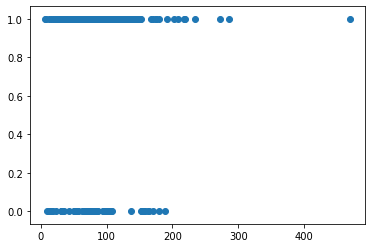

In [19]:
plt.scatter(total_mean.loc['Bgn'], biallelic.loc['Bgn'])

In [20]:
mean_expr = UMI.mean(axis=1)
mean_expr.name = 'mean_expr'
mean_expr_cast = UMI_cast.mean(axis=1)
mean_expr_cast.name = 'mean_expr_cast'

In [21]:
expr_df = expr_df.join(np.log10(mean_expr))

/home/nbserver/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


In [22]:
expr_df = expr_df.join(np.log10(mean_expr_cast))

/home/nbserver/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


In [23]:
expr_df['p_silent'] = expr_df['p_silent_c57']*expr_df['p_silent_cast']
expr_df['p_biallelic'] = (1-expr_df['p_silent_c57'])*(1-expr_df['p_silent_cast'])
expr_df['p_mono_cast']  = expr_df['p_silent_c57']*(1-expr_df['p_silent_cast'])
expr_df['p_mono_c57'] = (1-expr_df['p_silent_c57'])*expr_df['p_silent_cast']

In [64]:
expr_df['pois_mono_c57'] = get_ME_prob(10**expr_df['mean_expr'],10**expr_df['mean_expr_cast'])
expr_df['pois_mono_cast'] = get_ME_prob(10**expr_df['mean_expr_cast'],10**expr_df['mean_expr'])
expr_df['pois_biallelic'] = get_BI_prob(10**expr_df['mean_expr'],10**expr_df['mean_expr_cast'])
expr_df['pois_silent'] = get_SI_prob(10**expr_df['mean_expr'],10**expr_df['mean_expr_cast'])

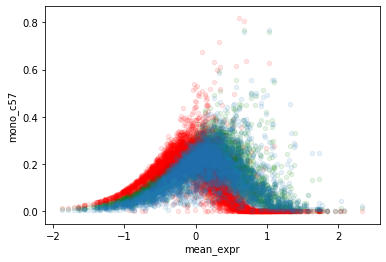

In [25]:
fig, ax = plt.subplots(1,1)
expr_df.plot(kind='scatter',x='mean_expr', y='p_mono_c57', ax=ax, alpha=0.1, color='green')
expr_df.plot(kind='scatter',x='mean_expr', y='pois_mono_c57', ax=ax, alpha=0.1, color='red')
expr_df.plot(kind='scatter',x='mean_expr', y='mono_c57', ax=ax, alpha=0.1)

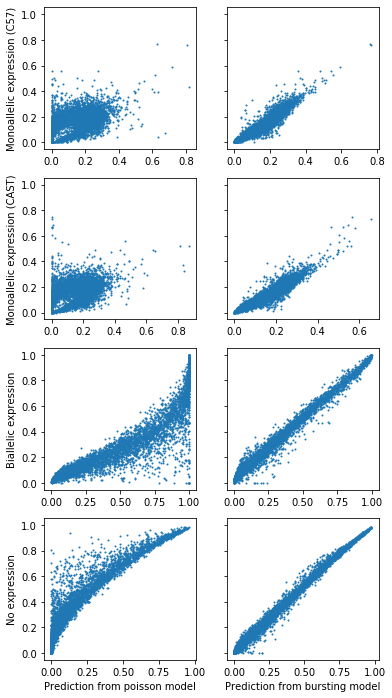

In [68]:
fig, ax = plt.subplots(4,2, sharey=True, figsize=(6,12))
ax[0][0].scatter(expr_df['pois_mono_c57'],expr_df['mono_c57'], s=1)
ax[0][1].scatter(expr_df['p_mono_c57'],expr_df['mono_c57'], s=1)
ax[1][0].scatter(expr_df['pois_mono_cast'],expr_df['mono_cast'], s=1)
ax[1][1].scatter(expr_df['p_mono_cast'],expr_df['mono_cast'], s=1)
ax[2][0].scatter(expr_df['pois_biallelic'],expr_df['biallelic'], s=1)
ax[2][1].scatter(expr_df['p_biallelic'],expr_df['biallelic'], s=1)
ax[3][0].scatter(expr_df['pois_silent'],expr_df['silent'], s=1)
ax[3][1].scatter(expr_df['p_silent'],expr_df['silent'], s=1)
ax[0][0].set_ylabel('Monoallelic expression (C57)')
ax[1][0].set_ylabel('Monoallelic expression (CAST)')
ax[2][0].set_ylabel('Biallelic expression')
ax[3][0].set_ylabel('No expression')
ax[3][0].set_xlabel('Prediction from poisson model')
ax[3][1].set_xlabel('Prediction from bursting model')
plt.savefig('Revision figures/poisson_vs_bursting_model_predictions.pdf')
plt.show()

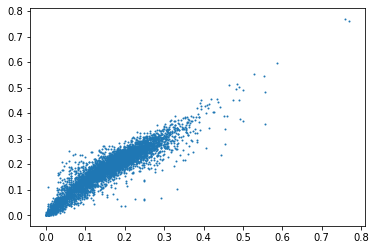

In [29]:
plt.scatter(expr_df['mono_c57'], expr_df['p_mono_c57'], s=1)

In [76]:
from scipy.stats import binom

In [87]:
expr_df

,silent_c57,silent_cast,biallelic,mono_cast,mono_c57,silent,p_silent_c57,p_silent_cast,mean_expr,p_silent,p_biallelic,p_mono_cast,p_mono_c57,mean_expr_cast,pois_mono_c57
0610007P14Rik,0.262443,0.280543,0.542986,0.176471,0.194570,0.085973,0.262426,0.278588,0.374109,0.073109,0.532094,0.189317,0.205479,0.334126,1.046772e-01
0610009B22Rik,0.193548,0.216590,0.635945,0.147465,0.170507,0.046083,0.170249,0.187380,0.589368,0.031901,0.674272,0.138348,0.155479,0.578412,2.217511e-02
0610009O20Rik,0.714286,0.718894,0.142857,0.138249,0.142857,0.576037,0.714446,0.719852,-0.327860,0.514296,0.079997,0.200151,0.205556,-0.323623,2.333040e-01
0610010F05Rik,0.632075,0.679245,0.183962,0.136792,0.183962,0.495283,0.635525,0.688765,-0.183321,0.437727,0.113437,0.197797,0.251038,-0.219126,2.629299e-01
0610012G03Rik,0.700000,0.400000,0.150000,0.450000,0.150000,0.250000,0.691902,0.375348,0.511883,0.259704,0.192454,0.432198,0.115644,0.908485,2.917696e-04
0610031J06Rik,0.031250,0.026786,0.946429,0.026786,0.022321,0.004464,0.019748,0.006571,1.054415,0.000130,0.973812,0.019618,0.006441,1.168134,4.016477e-07
1110002L01Rik,0.897727,0.977273,0.017045,0.005682,0.085227,0.892045,0.897486,0.977287,-0.754151,0.877102,0.002328,0.020384,0.100186,-1.467361,1.560836e-01
1110007C09Rik,0.334928,0.282297,0.444976,0.272727,0.220096,0.062201,0.314937,0.268853,0.468729,0.084672,0.500881,0.230265,0.184181,0.613847,1.554186e-02
1110037F02Rik,0.302752,0.288991,0.509174,0.201835,0.188073,0.100917,0.289314,0.285583,0.398736,0.082623,0.507726,0.206691,0.202960,0.414360,6.845549e-02
1110038B12Rik,0.117117,0.198198,0.698198,0.103604,0.184685,0.013514,0.129326,0.201072,0.664371,0.026004,0.695606,0.103322,0.175069,0.509166,3.917721e-02


In [91]:
expr_df['n_mono_c57'] = ((UMI==0)*(UMI_cast>0)).sum(axis=1).reindex(expr_df.index)

In [97]:
UMI.isnull().sum(axis=1).reindex(expr_df.index)

0610007P14Rik      3
0610009B22Rik      7
0610009O20Rik      7
0610010F05Rik     12
0610012G03Rik    204
0610031J06Rik      0
1110002L01Rik     48
1110007C09Rik     15
1110037F02Rik      6
1110038B12Rik      2
1110038F14Rik     11
1110051M20Rik     28
1110057K04Rik     13
1110058L19Rik      2
1110059E24Rik     13
1110059G10Rik     71
1190002N15Rik      7
1300002E11Rik      2
1500009L16Rik      5
1500011B03Rik     10
1500012F01Rik     27
1500015A07Rik      2
1600012H06Rik     63
1700001G11Rik      3
1700003M07Rik     15
1700012B09Rik      0
1700017B05Rik     59
1700020I14Rik      7
1700021K19Rik     16
1700025G04Rik     11
                ... 
Zik1              16
Zkscan14           6
Zmat2            152
Zmat3             11
Zmpste24           4
Zmym1             21
Zmym2             29
Zmym4             69
Zmynd8            30
Znfx1             14
Znhit1             9
Znhit3            12
Znhit6             1
Znrd1             25
Znrd1as          100
Znrf1             45
Znrf2        

In [92]:
expr_df

,silent_c57,silent_cast,biallelic,mono_cast,mono_c57,silent,p_silent_c57,p_silent_cast,mean_expr,p_silent,p_biallelic,p_mono_cast,p_mono_c57,mean_expr_cast,pois_mono_c57,n_mono_c57
0610007P14Rik,0.262443,0.280543,0.542986,0.176471,0.194570,0.085973,0.262426,0.278588,0.374109,0.073109,0.532094,0.189317,0.205479,0.334126,1.046772e-01,39
0610009B22Rik,0.193548,0.216590,0.635945,0.147465,0.170507,0.046083,0.170249,0.187380,0.589368,0.031901,0.674272,0.138348,0.155479,0.578412,2.217511e-02,32
0610009O20Rik,0.714286,0.718894,0.142857,0.138249,0.142857,0.576037,0.714446,0.719852,-0.327860,0.514296,0.079997,0.200151,0.205556,-0.323623,2.333040e-01,30
0610010F05Rik,0.632075,0.679245,0.183962,0.136792,0.183962,0.495283,0.635525,0.688765,-0.183321,0.437727,0.113437,0.197797,0.251038,-0.219126,2.629299e-01,29
0610012G03Rik,0.700000,0.400000,0.150000,0.450000,0.150000,0.250000,0.691902,0.375348,0.511883,0.259704,0.192454,0.432198,0.115644,0.908485,2.917696e-04,9
0610031J06Rik,0.031250,0.026786,0.946429,0.026786,0.022321,0.004464,0.019748,0.006571,1.054415,0.000130,0.973812,0.019618,0.006441,1.168134,4.016477e-07,6
1110002L01Rik,0.897727,0.977273,0.017045,0.005682,0.085227,0.892045,0.897486,0.977287,-0.754151,0.877102,0.002328,0.020384,0.100186,-1.467361,1.560836e-01,1
1110007C09Rik,0.334928,0.282297,0.444976,0.272727,0.220096,0.062201,0.314937,0.268853,0.468729,0.084672,0.500881,0.230265,0.184181,0.613847,1.554186e-02,57
1110037F02Rik,0.302752,0.288991,0.509174,0.201835,0.188073,0.100917,0.289314,0.285583,0.398736,0.082623,0.507726,0.206691,0.202960,0.414360,6.845549e-02,44
1110038B12Rik,0.117117,0.198198,0.698198,0.103604,0.184685,0.013514,0.129326,0.201072,0.664371,0.026004,0.695606,0.103322,0.175069,0.509166,3.917721e-02,23


In [31]:
## fit_nbinom
# Copyright (C) 2014 Gokcen Eraslan
#
# This program is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.
#
# This program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU General Public License for more details.
#
# You should have received a copy of the GNU General Public License
# along with this program.  If not, see <http://www.gnu.org/licenses/>.

from __future__ import print_function

import numpy as np
from scipy.special import gammaln
from scipy.special import psi
from scipy.special import factorial
from scipy.optimize import fmin_l_bfgs_b as optim

import sys


# X is a numpy array representing the data
# initial params is a numpy array representing the initial values of
# size and prob parameters
def fit_nbinom(X, initial_params=None):
    infinitesimal = np.finfo(np.float).eps

    def log_likelihood(params, *args):
        r, p = params
        X = args[0]
        N = X.size

        #MLE estimate based on the formula on Wikipedia:
        # http://en.wikipedia.org/wiki/Negative_binomial_distribution#Maximum_likelihood_estimation
        result = np.sum(gammaln(X + r)) \
            - np.sum(np.log(factorial(X))) \
            - N*(gammaln(r)) \
            + N*r*np.log(p) \
            + np.sum(X*np.log(1-(p if p < 1 else 1-infinitesimal)))

        return -result

    def log_likelihood_deriv(params, *args):
        r, p = params
        X = args[0]
        N = X.size

        pderiv = (N*r)/p - np.sum(X)/(1-(p if p < 1 else 1-infinitesimal))
        rderiv = np.sum(psi(X + r)) \
            - N*psi(r) \
            + N*np.log(p)

        return np.array([-rderiv, -pderiv])

    if initial_params is None:
        #reasonable initial values (from fitdistr function in R)
        m = np.mean(X)
        v = np.var(X)
        size = (m**2)/(v-m) if v > m else 10

        #convert mu/size parameterization to prob/size
        p0 = size / ((size+m) if size+m != 0 else 1)
        r0 = size
        initial_params = np.array([r0, p0])

    bounds = [(infinitesimal, None), (infinitesimal, 1)]
    optimres = optim(log_likelihood,
                     x0=initial_params,
                     #fprime=log_likelihood_deriv,
                     args=(X,),
                     approx_grad=1,
                     bounds=bounds)

    params = optimres[0]
    return {'size': params[0], 'prob': params[1], 'negll': optimres[1]}


In [81]:
def getBIC(row):
    binom.logpmf(4,8,0.5)

-1.296682202430203

In [38]:
fit_nbinom(np.random.negative_binomial(10,0.5, size=100))

{'size': 5.7451048020948,
 'prob': 0.3580597910290591,
 'negll': 303.0113430290121}